<a href="https://colab.research.google.com/github/MinahilRaza/Tennis-Ball-Tracking/blob/main/BallTracking_InitialExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contain initial experiments on the provided videos
# Optical Flow

## Sparse Optical Flow

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow


cap = cv.VideoCapture('video_cut.mp4')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
   
size = (frame_width, frame_height)
result = cv.VideoWriter('sparse_video1.avi', 
                         cv.VideoWriter_fourcc(*'MJPG'),
                         20, size)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0, 255, (100, 3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
i = 0
while(i<100):
    i += 1
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv.add(frame, mask)
    result.write(img)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)


No frames grabbed!


## Dense Optical Flow

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

cap = cv.VideoCapture(cv.samples.findFile("video_input8.mp4"))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
   
size = (frame_width, frame_height)
result = cv.VideoWriter('dense_video2.avi', 
                         cv.VideoWriter_fourcc(*'MJPG'),
                         20, size)

ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
while(1):
    ret, frame2 = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    result.write(bgr)
    
    prvs = next

No frames grabbed!


# Background Subtraction

In [ ]:
import cv2
import numpy as np
cap = cv2.VideoCapture(cv2.samples.findFile("video_cut.mp4"))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
   
size = (frame_width, frame_height)
result = cv2.VideoWriter('mog_video1.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         20, size)
BS_MOG = cv2.bgsegm.createBackgroundSubtractorMOG()
while(1):
  ret, frame = cap.read()
  if frame is None:
        print("No frame read")
        break
  # apply MOG to each frame
  MOG_mask = BS_MOG.apply(frame)
  rgb_img = cv2.cvtColor(MOG_mask, cv2.COLOR_GRAY2RGB)
  result.write(rgb_img)
  k = cv2.waitKey(30) & 0xff
  if k == 27:
    break
cap.release()
cv2.destroyAllWindows()

1
1
No frame read


In [ ]:
cap = cv.VideoCapture(cv.samples.findFile("video_input8.mp4"))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
   
size = (frame_width, frame_height)
result = cv.VideoWriter('mog2_video2.avi', 
                         cv.VideoWriter_fourcc(*'MJPG'),
                         20, size)
BS_MOG = cv.createBackgroundSubtractorMOG2()
while(1):
  ret, frame = cap.read()
  if frame is None:
        print("No frame read")
        break
  # apply MOG to each frame
  MOG_mask = BS_MOG.apply(frame)
  rgb_img = cv.cvtColor(MOG_mask, cv2.COLOR_GRAY2RGB)
  result.write(rgb_img)
  k = cv2.waitKey(30) & 0xff
  if k == 27:
    break
cap.release()
cv2.destroyAllWindows()

No frame read


## Defining RoI

In [ ]:
region_of_interest = np.zeros((frame_height, frame_width, 3))
pt0 = [726,76]
pt1 = [292,963]
pt2 = [1172,76]
pt3 = [1634, 953]
points = np.array([pt0, pt1, pt3, pt2])
cv2.fillPoly(region_of_interest, pts=[points], color=(255, 255, 255))
region_of_interest = cv2.cvtColor(region_of_interest.astype('uint8'), cv2.COLOR_BGR2GRAY) 
ret,region_of_interest = cv2.threshold(region_of_interest,250,255,0)


## Perspective Transformation

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
cap1 = cv2.VideoCapture(cv2.samples.findFile("homography_video_input8.avi"))
frame_width = int(cap1.get(3))
frame_height = int(cap1.get(4))
   
size = (frame_width, frame_height)
result = cv2.VideoWriter('knn_video2.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         20, size)
KNN = cv2.createBackgroundSubtractorKNN()
while(1):
  ret, frame = cap1.read()
  if frame is None:
        print("No frame read")
        break
  # apply MOG to each frame
  KNN_mask = KNN.apply(frame)
  # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
  KNN_mask = cv2.erode(KNN_mask.astype('uint8')*255, np.ones((3, 3)))
  KNN_mask = cv2.dilate(KNN_mask.astype('uint8')*255, np.ones((3, 3)))
  #KNN_mask = cv2.bitwise_and(KNN_mask.astype('uint8'), region_of_interest.astype('uint8'))
  contours, hierarchy = cv2.findContours(image=KNN_mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
  rgb_img = cv2.cvtColor(KNN_mask, cv2.COLOR_GRAY2RGB)
  #contours = [c for c in contours if cv2.contourArea(c)<50 and cv2.contourArea(c)>5]
  cv2.drawContours(image=rgb_img, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
  cv2_imshow(rgb_img)
  result.write(rgb_img)
  k = cv2.waitKey(30) & 0xff
  if k == 27:
    break
cap1.release()
cv2.destroyAllWindows()

### Finding Correspondences
we need four correspondences to calculate the homography

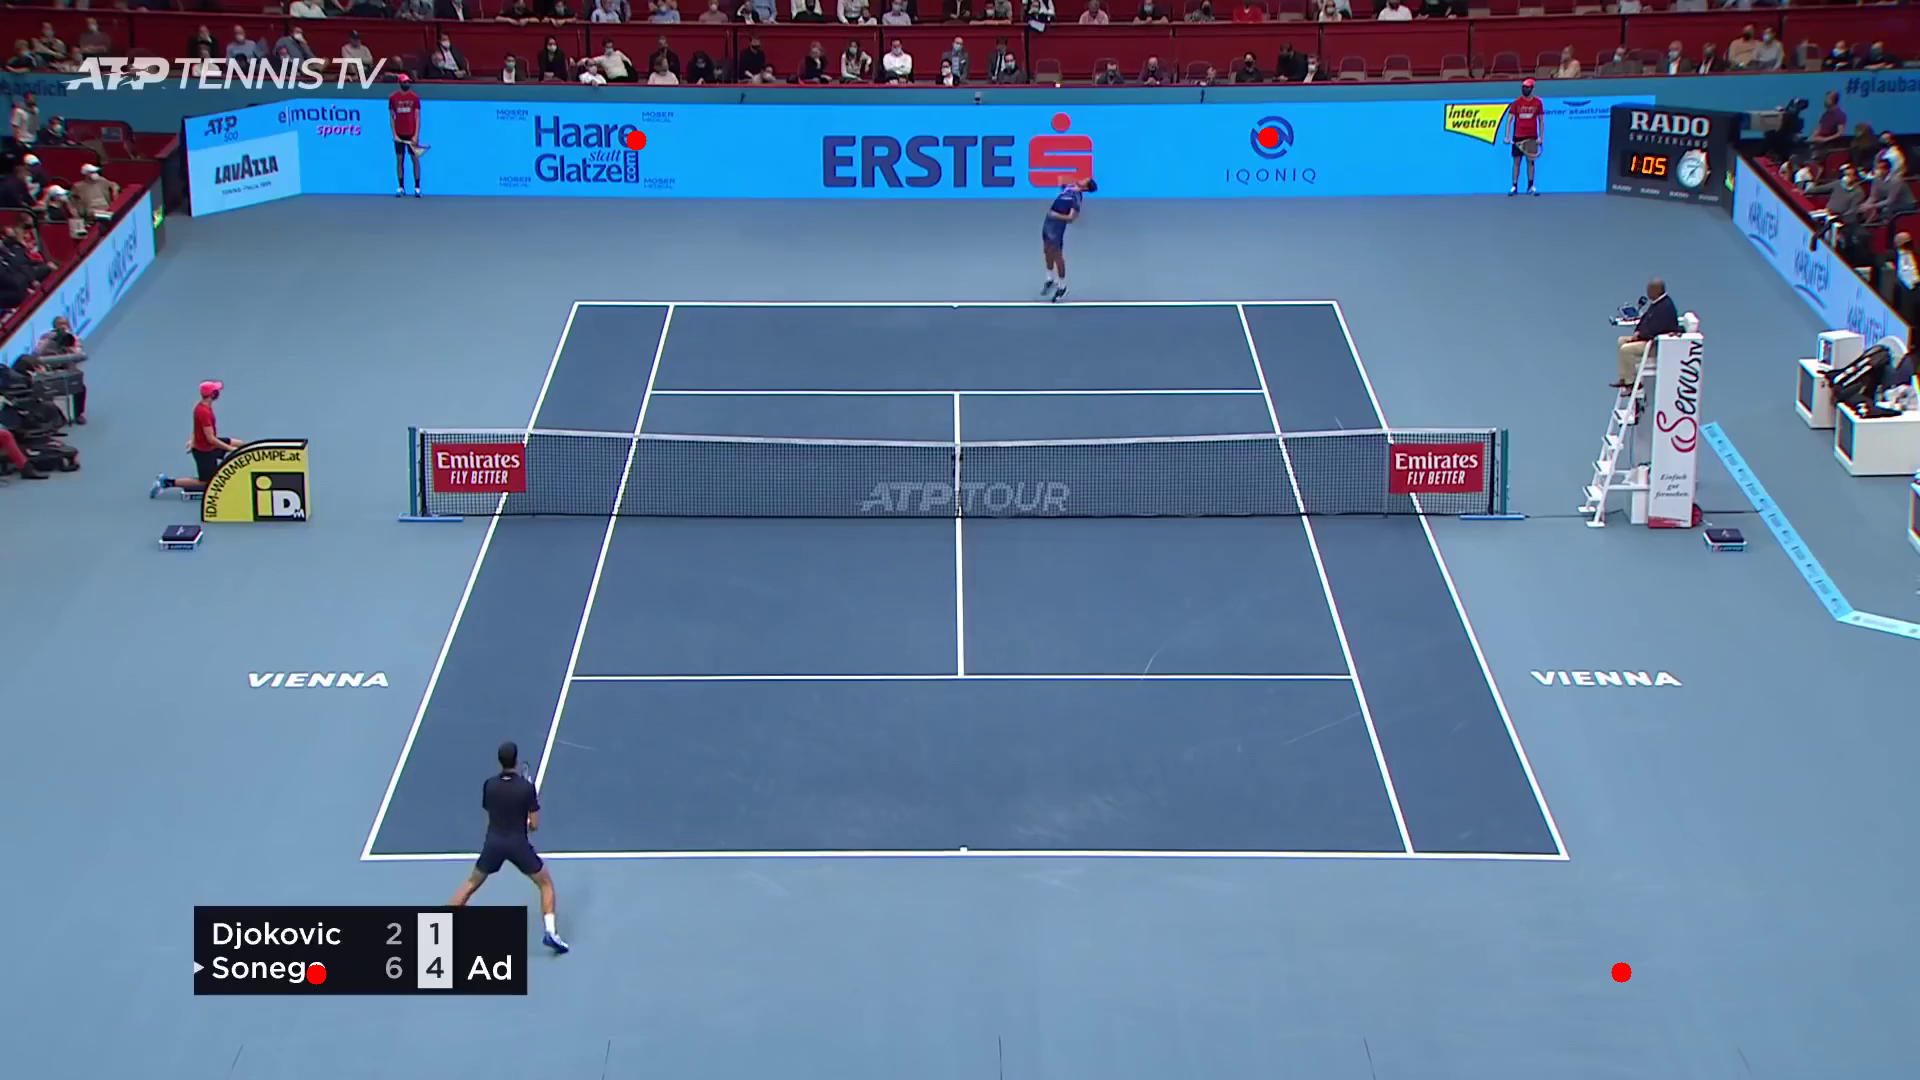

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

cap1 = cv2.VideoCapture(cv2.samples.findFile("video_cut.mp4"))
frame_width = int(cap1.get(3))
frame_height = int(cap1.get(4))

pt0 = [636,140]
pt1 = [316,974]
pt2 = [1268,137]
pt3 = [1621, 972]
srcPts = np.array([pt0, pt1, pt2, pt3]).astype(np.float32)
ret, im_photo = cap1.read()

# visualize points on the image
cv2.circle(im_photo, pt0, radius=10, thickness=-1, color=(0,0,255))
cv2.circle(im_photo, pt1, radius=10, thickness=-1, color=(0,0,255))
cv2.circle(im_photo, pt2, radius=10, thickness=-1, color=(0,0,255))
cv2.circle(im_photo, pt3, radius=10, thickness=-1, color=(0,0,255))

cv2_imshow(im_photo)

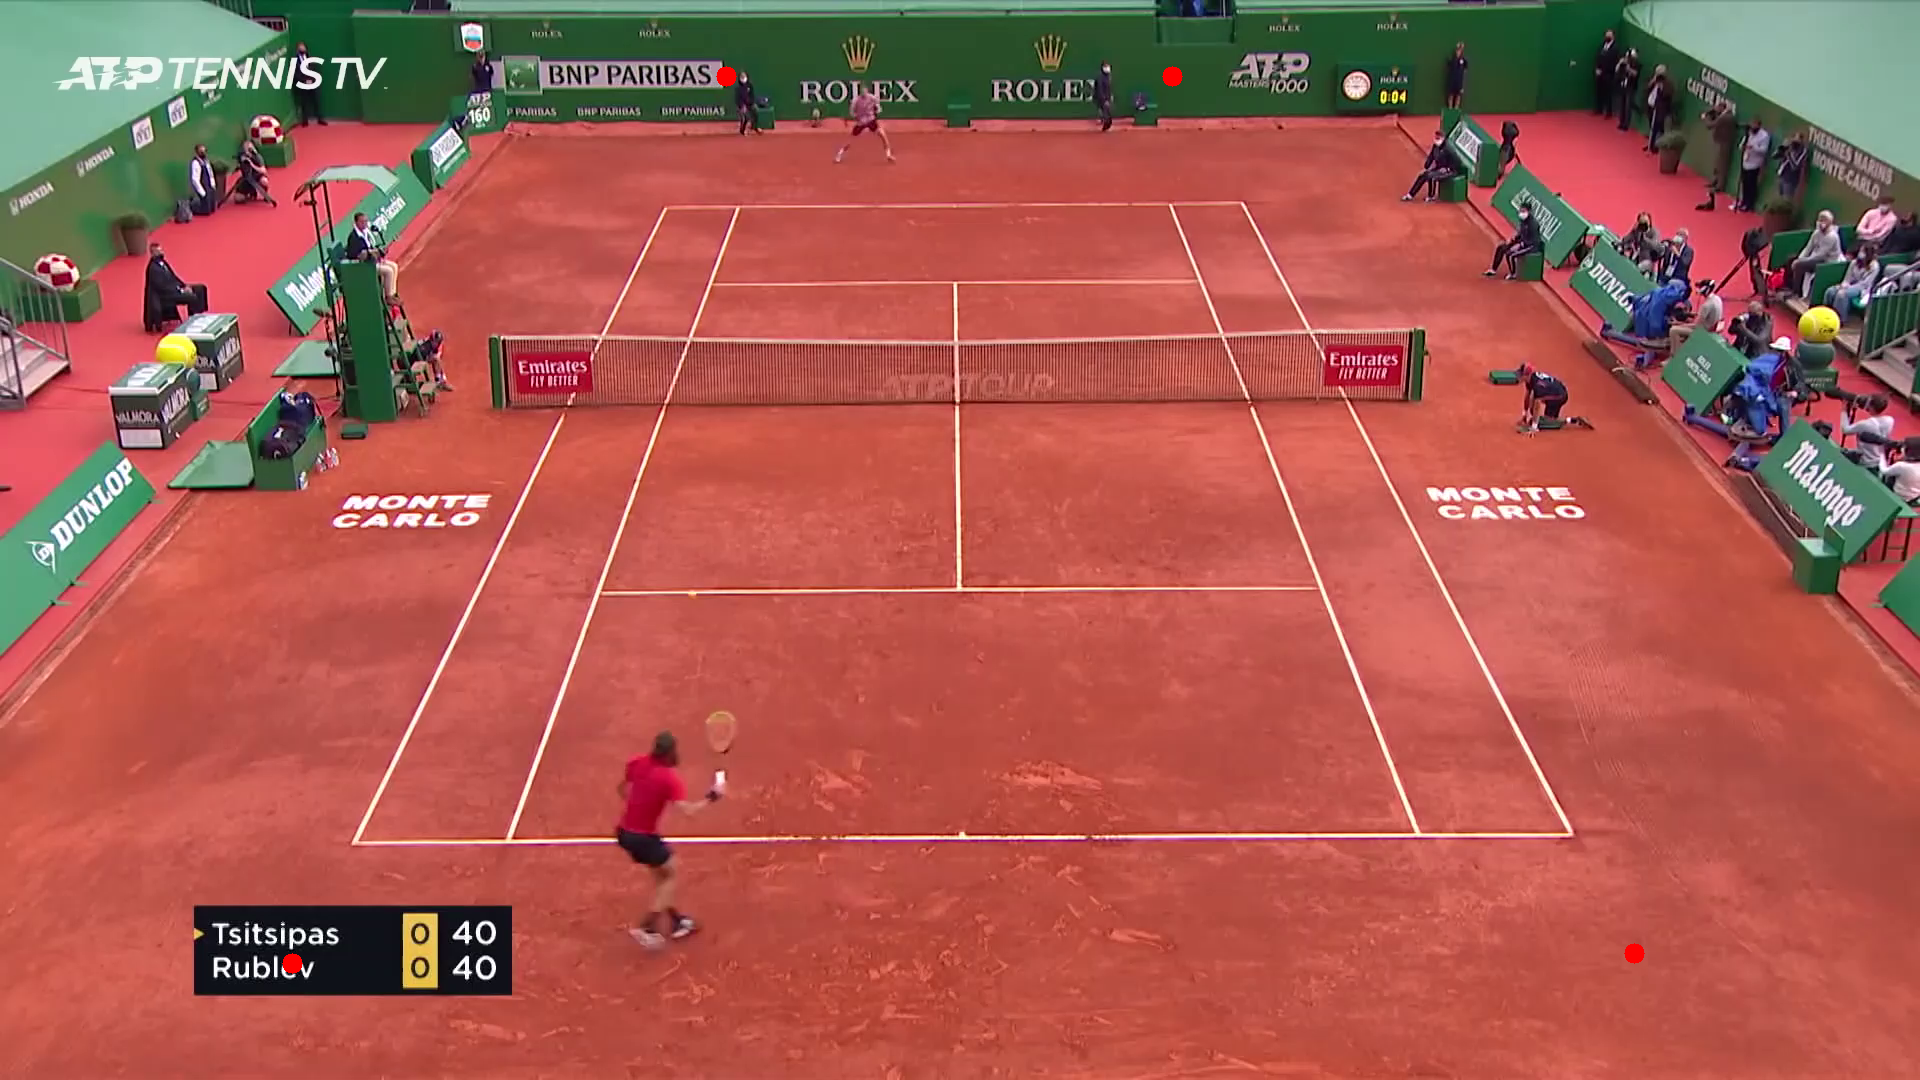

In [ ]:
cap1 = cv2.VideoCapture(cv2.samples.findFile("video_input8.mp4"))
frame_width = int(cap1.get(3))
frame_height = int(cap1.get(4))

pt0 = [726,76]
pt1 = [292,963]
pt2 = [1172,76]
pt3 = [1634, 953]
srcPts = np.array([pt0, pt1, pt2, pt3]).astype(np.float32)
ret, im_photo = cap1.read()

# visualize points on the image
cv2.circle(im_photo, pt0, radius=10, thickness=-1, color=(0,0,255))
cv2.circle(im_photo, pt1, radius=10, thickness=-1, color=(0,0,255))
cv2.circle(im_photo, pt2, radius=10, thickness=-1, color=(0,0,255))
cv2.circle(im_photo, pt3, radius=10, thickness=-1, color=(0,0,255))

cv2_imshow(im_photo)

In [ ]:
# make a function and pass the video only along with the points
cap1 = cv2.VideoCapture(cv2.samples.findFile("knn_video2.avi"))
dstPts = np.array([[0,0], [0,frame_height], [frame_width, 0]]).astype(np.float32)
dstPts = np.array([[0,0], [0,frame_width], [frame_height, 0], [frame_height, frame_width]]).astype(np.float32)

size = (frame_height, frame_width)
result = cv2.VideoWriter('homography_video2_bg.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         20, size)

# find homography using OpenCV in-built function 
h, status = cv2.findHomography(srcPts, dstPts)

while(1):
  ret, frame = cap1.read()
  if frame is None:
        print("No frame read")
        break
  # find the destination image
  rgb_img = cv2.warpPerspective(src=frame, M=h, dsize=(frame_height, frame_width))
  result.write(rgb_img)
  k = cv2.waitKey(30) & 0xff
  if k == 27:
    break
cap1.release()
cv2.destroyAllWindows()

No frame read


# Color-based tracking

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

cap = cv.VideoCapture(cv.samples.findFile("video_input8.mp4"))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
   
size = (frame_width, frame_height)
result = cv.VideoWriter('dense_video2.avi', 
                         cv.VideoWriter_fourcc(*'MJPG'),
                         20, size)
lower_yellow = np.array([30, 255, 135], dtype=np.uint8)
upper_yellow = np.array([40, 255, 185], dtype=np.uint8)
#lower_yellow = np.array([230, 59, 75], dtype=np.uint8)
#pper_yellow = np.array([240,150,255], dtype=np.uint8)
greenLower = (44, 86, 56)
greenUpper = (94, 177, 255)

i = 0
while(1):
    i += 1
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv, lower_yellow, upper_yellow)
    bgr = cv.cvtColor(mask, cv.COLOR_GRAY2BGR)
    cv2_imshow(bgr)
    cv2_imshow(frame)
    result.write(bgr)
    if i ==5:
      break

# particle filter for the ball

In [ ]:
# BAckground subtraction before tracking the objects might improve the results

import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
#cap = cv.VideoCapture('slow_traffic_small.mp4')
cap = cv.VideoCapture('video_input8.mp4') #486, 748

# take first frame of the video
ret,frame = cap.read()
# setup initial location of window
#y,h,x,w = 200,120,300,100 # simply hardcoded the values

# first player
y,x = 800, 500
h =  20
w = 20

# Second Player
x,y =  1050, 220
h,w = 20,20

# Ball in Video 2
x,y =  691, 594
h,w = 1,1
track_window = (x, y, w, h)
# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
while(1):
  ret, frame = cap.read()
  if ret == True:
      hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
      dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
      # apply camshift to get the new location
      ret, track_window = cv.CamShift(dst, track_window, term_crit)
      # Draw it on image
      pts = cv.boxPoints(ret)
      pts = np.int0(pts)
      img2 = cv.polylines(frame,[pts],True, 255,2)
      cv2_imshow(img2)
      k = cv.waitKey(30) & 0xff
      if k == 27:
        break
  else:
      break
